# Introduction

In this notebook, we will attempt to use the powerful tools given to us by NLTK, spacy, and other libraries to create an application that can predict the next word in a tweet that the user wishes to type. The goal of this project isn't just to give one word to the user but a few different options ordered by the probability of each option being the desired next word. In order to achieve a high accuracy score, we will be deploying an unsupervised learning method prior to our supervised learning modeling. We will split the tweets into different categories using LDA. Only after that will we begin modeling but on each cluster individually.

## Data

The data we will be using consists of tweets from the twint API. Information on this API be accessed <a href='https://github.com/twintproject/twint'>here</a>. This API contains not just tweets but loads of information about each tweet. We will likely be using just the tweet text column because the other columns won't be much use to us. The Twint API uses web scraping to retrieve this data for us to access through its API. With just a few simple steps, it can be set up without much thought. The specific data we will be accessing from twint are a list of the ten thousand most popular recent tweets. This data will be stored into a pandas data frame to be modified throughout this process. 

## OSEMN Process

# Obtain (O)

In [245]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random
from wordcloud import WordCloud

import twint
import nest_asyncio
nest_asyncio.apply()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Embedding
# from keras.preprocessing.sequence import pad_sequences


import nltk
# nltk.download('punkt')
from nltk.util import ngrams
import spacy
from pickle import dump, load

ImportError: cannot import name 'Exit'

In [5]:
# c = twint.Config()
# c.Search = 'trump'
# c.Limit = 15000
# c.Min_likes = 1000
# c.Lang = 'en'
# c.Store_csv = True
# c.Output = 'trump_tweets.csv'
# c.Hide_output = True
# twint.run.Search(c)

In [6]:
df = pd.read_csv('trump_tweets.csv')

In [7]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1361774593984364549,1361774593984364549,2021-02-16 15:28:58 Eastern Standard Time,2021-02-16,15:28:58,-500,3932768472,emeraldrobinson,Emerald Robinson ✝️,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1361769607317639169,1361769607317639169,2021-02-16 15:09:09 Eastern Standard Time,2021-02-16,15:09:09,-500,4639413136,marklutchman,Mark Lutchman 🇺🇸,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1361768846852554757,1361768846852554757,2021-02-16 15:06:08 Eastern Standard Time,2021-02-16,15:06:08,-500,783792992,ilhanmn,Ilhan Omar,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1361768060017922052,1361768060017922052,2021-02-16 15:03:00 Eastern Standard Time,2021-02-16,15:03:00,-500,25202268,saracarterdc,Sara A. Carter,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1361762378556317700,1361762378556317700,2021-02-16 14:40:26 Eastern Standard Time,2021-02-16,14:40:26,-500,4765364386,chuckcallesto,Chuck Callesto,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [8]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [9]:
# Drop unecessary columns
df.drop(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id','place','mentions',
       'urls', 'photos', 'replies_count', 'retweets_count','hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'], inplace=True, axis=1)
df.head()

,username,name,tweet,language,likes_count
0,emeraldrobinson,Emerald Robinson ✝️,Why would President Trump meet with Lindsey Gr...,en,1455
1,marklutchman,Mark Lutchman 🇺🇸,Liberals are saying President Trump lost most ...,en,2088
2,ilhanmn,Ilhan Omar,Republicans love Cancel Culture when they can ...,en,4431
3,saracarterdc,Sara A. Carter,Poll: Majority of GOP voters still favor Trump...,en,1428
4,chuckcallesto,Chuck Callesto,Would you SUPPORT a Trump / DeSantis 2024 Pres...,en,3067


In [10]:
# Discard non-english tweets
df = df[df['language'] == 'en']
df['language'].value_counts()

en    28982
Name: language, dtype: int64

In [11]:
# Drop Language column
df.drop(['language'], inplace=True, axis=1)
df.head()

,username,name,tweet,likes_count
0,emeraldrobinson,Emerald Robinson ✝️,Why would President Trump meet with Lindsey Gr...,1455
1,marklutchman,Mark Lutchman 🇺🇸,Liberals are saying President Trump lost most ...,2088
2,ilhanmn,Ilhan Omar,Republicans love Cancel Culture when they can ...,4431
3,saracarterdc,Sara A. Carter,Poll: Majority of GOP voters still favor Trump...,1428
4,chuckcallesto,Chuck Callesto,Would you SUPPORT a Trump / DeSantis 2024 Pres...,3067


# Scrub (S)

## Data inspection

In [12]:
# Check for null values
df.isnull().sum()

username       0
name           0
tweet          0
likes_count    0
dtype: int64

# Explore (E)

> Because our project is focused on predicting the next desired word, there will be no lemitization necessary during preprocessing. Furthermore, the list of stop-words will eventually be focused on misspelled words and punctuation

## EDA - Word Clouds for topics with LDA topic modeling

In [222]:
from sklearn.feature_extraction import text 

additional_stop_words = ['https', 'says', 'said', 'just', 'did', 'thing']

stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

cv = CountVectorizer(max_df=0.9, min_df=2, stop_words=stop_words)
dtm = cv.fit_transform(df['tweet'])
dtm

<28982x18874 sparse matrix of type '<class 'numpy.int64'>'
	with 393069 stored elements in Compressed Sparse Row format>

In [223]:
# LDA - tune to see how many topics should implement
# Using 4 different topics 
LDA = LatentDirichletAllocation(n_components=4, random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=4, random_state=42)

In [224]:
# Grab vocab of words
cv.get_feature_names()[1500]

'amnesty'

In [225]:
random_word_id = random.randint(0,7859)
cv.get_feature_names()[random_word_id]

'doe'

In [226]:
# grab topics
single_topic = LDA.components_[0]
single_topic.argsort()

array([ 3196,  8711,  3184, ...,  2366,  5350, 12935], dtype=int64)

In [227]:
# Top 15 words for topic 0
top_fifteen = single_topic.argsort()[-15:]
for index in top_fifteen:
    print(cv.get_feature_names()[index])

office
america
today
lawyer
senate
time
day
house
defense
lawyers
trial
impeachment
biden
donald
president


In [228]:
# highest probablility topics
for index,topic in enumerate(LDA.components_):
    print(f"Top 20 words for topic #{index}")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-25:]])
    print('\n')

Top 20 words for topic #0
['election', 'evidence', 'twitter', 'united', 'mccarthy', 'managers', 'states', 'january', 'joe', 'amp', 'office', 'america', 'today', 'lawyer', 'senate', 'time', 'day', 'house', 'defense', 'lawyers', 'trial', 'impeachment', 'biden', 'donald', 'president']


Top 20 words for topic #1
['supreme', 'news', 'legal', 'covid', 'amp', 'media', 'attorney', 'lawyer', 'democrats', 'plan', 'office', 'years', 'like', 'defense', 'donald', 'impeachment', 'breaking', 'team', 'president', 'tax', 'court', 'don', 'administration', 'new', 'biden']


Top 20 words for topic #2
['jan', 'office', 'knew', 'americans', 'mcconnell', 'election', 'january', 'going', 'gop', 'incited', 'stop', 'supporters', 'know', 'like', 'attack', 'didn', 'mob', 'pence', 'insurrection', 'biden', 'amp', 'donald', 'people', 'president', 'capitol']


Top 20 words for topic #3
['acquit', 'cruz', 'don', 'people', 'right', 'amp', 'mcconnell', 'insurrection', 'office', 'house', 'like', 'president', 'voted', 'se

In [231]:
topic_results = LDA.transform(dtm)
topic_results[0].argmax()
df['Topic'] = topic_results.argmax(axis=1)
df[['tweet', 'Topic']].head(15)

,tweet,Topic
0,Why would President Trump meet with Lindsey Gr...,3
1,Liberals are saying President Trump lost most ...,3
2,Republicans love Cancel Culture when they can ...,3
3,Poll: Majority of GOP voters still favor Trump...,3
4,Would you SUPPORT a Trump / DeSantis 2024 Pres...,0
5,"If anyone gets a chance to interview David, I'...",3
6,Demolition crews are currently ripping out Don...,0
7,"@JDVance1 For five straight years, @twitter an...",0
8,Trump surprises supporters with drive-by at Pr...,0
9,POLITICO 2024 PRIMARY POLL: Donald Trump 53% ...,3


In [233]:
# Visiualize top 20 words for each topic
for index,topic in enumerate(LDA.components_):
    print(f"Top 20 words for topic #{index}")
    print([cv.get_feature_names()[index] for index in topic.argsort()[-20:]])
    print('\n')

Top 20 words for topic #0
['managers', 'states', 'january', 'joe', 'amp', 'office', 'america', 'today', 'lawyer', 'senate', 'time', 'day', 'house', 'defense', 'lawyers', 'trial', 'impeachment', 'biden', 'donald', 'president']


Top 20 words for topic #1
['media', 'attorney', 'lawyer', 'democrats', 'plan', 'office', 'years', 'like', 'defense', 'donald', 'impeachment', 'breaking', 'team', 'president', 'tax', 'court', 'don', 'administration', 'new', 'biden']


Top 20 words for topic #2
['election', 'january', 'going', 'gop', 'incited', 'stop', 'supporters', 'know', 'like', 'attack', 'didn', 'mob', 'pence', 'insurrection', 'biden', 'amp', 'donald', 'people', 'president', 'capitol']


Top 20 words for topic #3
['amp', 'mcconnell', 'insurrection', 'office', 'house', 'like', 'president', 'voted', 'senators', 'convict', 'donald', 'election', 'party', 'vote', 'gop', 'republicans', 'trial', 'impeachment', 'senate', 'republican']




In [234]:
# Number of terms per topic
terms_count = 20
top_words_per_topic = []
terms = cv.get_feature_names()

for idx,topic in enumerate(LDA.components_):
    abs_topic = abs(topic)
    topic_terms = [[[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]    
    top_words_per_topic.append(topic_terms_sorted)

In [235]:
# Create word clouds 1 topic at a time
def topicWordCloud(topic):
    for i in range(len(topic)):
        dict_word_frequency[topic[i][0]] = topic[i][1]
        
    wordcloud = WordCloud(background_color="white",mask=None, max_words=100,
        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
        contour_width=3,contour_color='black').generate_from_frequencies(dict_word_frequency)
    dict_word_frequency.clear()
    return wordcloud

In [236]:
# Create list of word clouds to later plot
word_cloud_list = []
for topic in top_words_per_topic:
    word_cloud_list.append(topicWordCloud(topic))

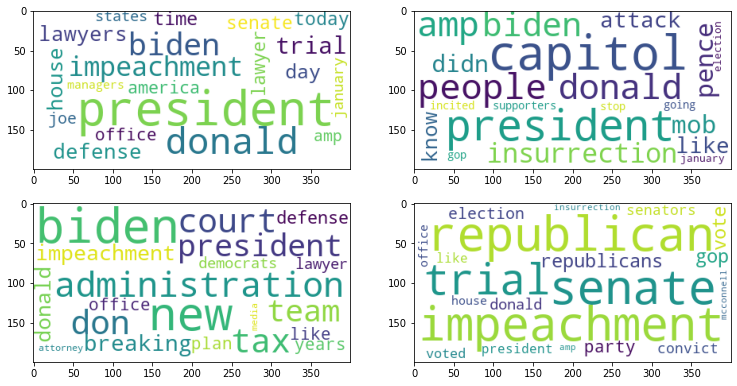

In [237]:
# Plot word clouds for each topic
rows = 2
cols = 2

row = 0
col = 0

fig, ax = plt.subplots(rows, cols, figsize=(12.5,6.5))
for i in range(4):
    ax[row][col].imshow(word_cloud_list[i])
    row=row+1
    if row==rows:
        row=0
        col=col+1

* Topic 0 - Trump impeachment trial
* Topic 1 - Trump capital riot
* Topic 2 - Biden administration vs Trump administration
* Topic 3 - misc

In [238]:
# Function to visualize next word predictions
def extract_ngrams(data, num=2):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [' '.join(grams) for grams in n_grams]

In [239]:
df['2_ngrams'] = df['tweet'].map(extract_ngrams)
df.head()

,username,name,tweet,likes_count,Topic,2_ngrams
0,emeraldrobinson,Emerald Robinson ✝️,Why would President Trump meet with Lindsey Gr...,1455,3,"[Why would, would President, President Trump, ..."
1,marklutchman,Mark Lutchman 🇺🇸,Liberals are saying President Trump lost most ...,2088,3,"[Liberals are, are saying, saying President, P..."
2,ilhanmn,Ilhan Omar,Republicans love Cancel Culture when they can ...,4431,3,"[Republicans love, love Cancel, Cancel Culture..."
3,saracarterdc,Sara A. Carter,Poll: Majority of GOP voters still favor Trump...,1428,3,"[Poll :, : Majority, Majority of, of GOP, GOP ..."
4,chuckcallesto,Chuck Callesto,Would you SUPPORT a Trump / DeSantis 2024 Pres...,3067,0,"[Would you, you SUPPORT, SUPPORT a, a Trump, T..."


In [240]:
def get_top_n_ngram(corpus, n=None, ngrams=2):
    vec = CountVectorizer(ngram_range=(ngrams, ngrams)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

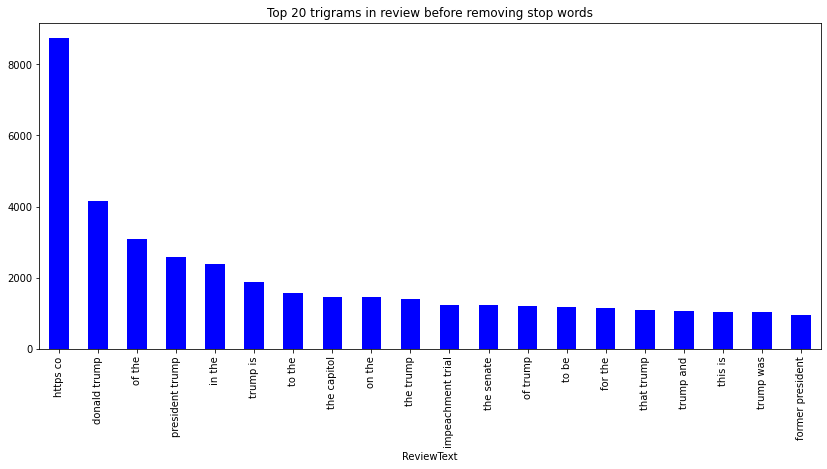

In [241]:
common_phrases = get_top_n_ngram(df['tweet'], 20, 2)
phrases_df = pd.DataFrame(common_phrases, columns = ['ReviewText' , 'count'])
phrases_df.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', figsize=(14, 6), color='blue', title='Top 20 trigrams in review before removing stop words')


In [28]:
phrases_df.head()

,ReviewText,count
0,https co,4480
1,donald trump,2087
2,of the,1584
3,president trump,1259
4,in the,1214


# Model (M)

## Final Modeling - try out all different models
> Goal is to get High accuracy score

In [242]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

NameError: name 'spacy' is not defined

In [31]:
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '-#$&()--.*+,-/:;<=>?@[\\]^_{|}~\t\n ']

In [32]:
df['tweet'][0]

'Why would President Trump meet with Lindsey Graham about the future of the GOP?'

In [33]:
tweet_tokens = df['tweet'].map(separate_punc)

In [34]:
tweet_tokens.head()

0    [why, would, president, trump, meet, with, lin...
1    [liberals, are, saying, president, trump, lost...
2    [republicans, love, cancel, culture, when, the...
3    [poll, majority, of, gop, voters, still, favor...
4    [would, you, support, a, trump, desantis, 2024...
Name: tweet, dtype: object

In [77]:
def get_text_seq(tweet_token_list, train_len=2):
    
    text_sequences = []

    for tweet in tweet_token_list:
        for i in range(len(tweet)-train_len):
            seq = tweet[i:i+train_len]
            
            if len(seq) == train_len:
                text_sequences.append(seq)
            
    return text_sequences

In [78]:
# def get_text_seq(token, train_len=2):
# #     train_len = 2+1

    
#     text_sequences = []

#     for i in range(train_len, len(tokens)):
        
#         seq = token[i-train_len:i]
#         text_sequences.append(seq)
            
#     return text_sequences

In [202]:
text_sequences = get_text_seq(tweet_tokens, train_len=3)
text_sequences = text_sequences[:100000]

In [203]:
len(text_sequences)

100000

In [204]:
text_sequences

[['why', 'would', 'president'],
 ['would', 'president', 'trump'],
 ['president', 'trump', 'meet'],
 ['trump', 'meet', 'with'],
 ['meet', 'with', 'lindsey'],
 ['with', 'lindsey', 'graham'],
 ['lindsey', 'graham', 'about'],
 ['graham', 'about', 'the'],
 ['about', 'the', 'future'],
 ['the', 'future', 'of'],
 ['future', 'of', 'the'],
 ['liberals', 'are', 'saying'],
 ['are', 'saying', 'president'],
 ['saying', 'president', 'trump'],
 ['president', 'trump', 'lost'],
 ['trump', 'lost', 'most'],
 ['lost', 'most', 'of'],
 ['most', 'of', 'his'],
 ['of', 'his', 'support'],
 ['his', 'support', 'after'],
 ['support', 'after', 'jan'],
 ['after', 'jan', '6th'],
 ['jan', '6th', '  '],
 ['6th', '  ', 'i'],
 ['  ', 'i', 'say'],
 ['i', 'say', 'they'],
 ['say', 'they', '’re'],
 ['they', '’re', 'dead'],
 ['’re', 'dead', 'wrong'],
 ['dead', 'wrong', '  '],
 ['wrong', '  ', 'raise'],
 ['  ', 'raise', 'your'],
 ['raise', 'your', 'hand'],
 ['your', 'hand', 'if'],
 ['hand', 'if', 'you'],
 ['if', 'you', '’d'],
 

In [206]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)

In [207]:
sequences = tokenizer.texts_to_sequences(text_sequences)

In [208]:
sequences

[[114, 62, 20],
 [62, 20, 2],
 [20, 2, 1538],
 [2, 1538, 26],
 [1538, 26, 290],
 [26, 290, 195],
 [290, 195, 32],
 [195, 32, 1],
 [32, 1, 254],
 [1, 254, 5],
 [254, 5, 1],
 [1086, 27, 173],
 [27, 173, 20],
 [173, 20, 2],
 [20, 2, 266],
 [2, 266, 150],
 [266, 150, 5],
 [150, 5, 21],
 [5, 21, 257],
 [21, 257, 68],
 [257, 68, 320],
 [68, 320, 286],
 [320, 286, 33],
 [286, 33, 18],
 [33, 18, 170],
 [18, 170, 25],
 [170, 25, 272],
 [25, 272, 805],
 [272, 805, 484],
 [805, 484, 33],
 [484, 33, 1392],
 [33, 1392, 153],
 [1392, 153, 605],
 [153, 605, 54],
 [605, 54, 24],
 [54, 24, 628],
 [24, 628, 97],
 [628, 97, 63],
 [97, 63, 10],
 [63, 10, 20],
 [10, 20, 2],
 [20, 2, 2403],
 [2, 2403, 4100],
 [2403, 4100, 1776],
 [64, 359, 1422],
 [359, 1422, 1238],
 [1422, 1238, 91],
 [1238, 91, 25],
 [91, 25, 93],
 [25, 93, 1422],
 [93, 1422, 1204],
 [1422, 1204, 64],
 [1204, 64, 10],
 [64, 10, 19],
 [10, 19, 4407],
 [19, 4407, 65],
 [4407, 65, 725],
 [65, 725, 224],
 [725, 224, 2],
 [224, 2, 106],
 [2, 1

In [209]:
print(sequences[0])
print(sequences[1])

[114, 62, 20]
[62, 20, 2]


In [210]:
tokenizer.index_word

{1: 'the',
 2: 'trump',
 3: 'to',
 4: 'and',
 5: 'of',
 6: 'a',
 7: 'is',
 8: 'in',
 9: 'that',
 10: 'for',
 11: 'he',
 12: 'it',
 13: '"',
 14: '’s',
 15: 'on',
 16: 'was',
 17: "'s",
 18: 'i',
 19: 'not',
 20: 'president',
 21: 'his',
 22: 'be',
 23: 'this',
 24: 'you',
 25: 'they',
 26: 'with',
 27: 'are',
 28: 'donald',
 29: 'who',
 30: 'have',
 31: 'we',
 32: 'about',
 33: '  ',
 34: 'but',
 35: 'impeachment',
 36: 'will',
 37: 'senate',
 38: 'as',
 39: 'n’t',
 40: 'did',
 41: 'by',
 42: 'trial',
 43: 'from',
 44: 'what',
 45: 'has',
 46: 'at',
 47: 'do',
 48: 'him',
 49: "n't",
 50: 'now',
 51: '“',
 52: 'an',
 53: 'just',
 54: 'if',
 55: 'amp',
 56: 'no',
 57: 'voted',
 58: 'all',
 59: 'mcconnell',
 60: '!',
 61: 'more',
 62: 'would',
 63: 'vote',
 64: 'republicans',
 65: 'their',
 66: 'gop',
 67: '”',
 68: 'after',
 69: 'convict',
 70: 'people',
 71: 'because',
 72: 'witnesses',
 73: 'so',
 74: 'insurrection',
 75: 'republican',
 76: 'our',
 77: 'been',
 78: 'guilty',
 79: 'out

In [211]:
tokenizer.word_counts

OrderedDict([('why', 422),
             ('would', 739),
             ('president', 1824),
             ('trump', 10985),
             ('meet', 19),
             ('with', 1538),
             ('lindsey', 138),
             ('graham', 214),
             ('about', 1296),
             ('the', 13001),
             ('future', 161),
             ('of', 5576),
             ('liberals', 29),
             ('are', 1492),
             ('saying', 240),
             ('lost', 153),
             ('most', 295),
             ('his', 1799),
             ('support', 158),
             ('after', 675),
             ('jan', 124),
             ('6th', 141),
             ('  ', 1293),
             ('i', 1875),
             ('say', 241),
             ('they', 1574),
             ('’re', 151),
             ('dead', 42),
             ('wrong', 79),
             ('raise', 22),
             ('your', 283),
             ('hand', 61),
             ('if', 843),
             ('you', 1582),
             ('’d', 58),
      

In [212]:
sequences = np.array(sequences)

In [213]:
sequences

array([[ 114,   62,   20],
       [  62,   20,    2],
       [  20,    2, 1538],
       ...,
       [ 501,  687,   13],
       [ 687,   13,  360],
       [  13,  360,   13]])

In [215]:
vocabulary_size = len(tokenizer.word_counts)

In [216]:
X = sequences[:, :-1]
y = sequences[:, -1]

In [217]:
y

array([  20,    2, 1538, ...,   13,  360,   13])

In [218]:
y = to_categorical(y, num_classes=vocabulary_size+1)

In [219]:
y.shape

(100000, 8812)

In [220]:
seq_len = X.shape[1]

In [221]:
X.shape

(100000, 2)

In [223]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
    model.add(LSTM(seq_len*2, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(50, activation='relu'))
    
    model.add(Dense(vocabulary_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    return model

In [224]:
model = create_model(vocabulary_size+1, seq_len)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2, 2)              17624     
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 4)              112       
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                11000     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 8812)              449412    
Total params: 480,698
Trainable params: 480,698
Non-trainable params: 0
_________________________________________________________________


In [226]:
history = model.fit(X, y, batch_size=8, epochs=500, verbose=1)

Epoch 1/500
100000/100000 [==============================] - 182s 2ms/step - loss: 6.8627 - accuracy: 0.0479
Epoch 2/500
100000/100000 [==============================] - 169s 2ms/step - loss: 6.5690 - accuracy: 0.0580
Epoch 3/500
100000/100000 [==============================] - 168s 2ms/step - loss: 6.4175 - accuracy: 0.0669
Epoch 4/500
100000/100000 [==============================] - 169s 2ms/step - loss: 6.2834 - accuracy: 0.0752
Epoch 5/500
100000/100000 [==============================] - 171s 2ms/step - loss: 6.1812 - accuracy: 0.0801
Epoch 6/500
100000/100000 [==============================] - 168s 2ms/step - loss: 6.0978 - accuracy: 0.0843
Epoch 7/500
100000/100000 [==============================] - 168s 2ms/step - loss: 6.0238 - accuracy: 0.0885
Epoch 8/500
100000/100000 [==============================] - 168s 2ms/step - loss: 5.9555 - accuracy: 0.0930
Epoch 9/500
100000/100000 [==============================] - 167s 2ms/step - loss: 5.8921 - accuracy: 0.0966
Epoch 10/500
100000

100000/100000 [==============================] - 172s 2ms/step - loss: 5.2666 - accuracy: 0.1407
Epoch 347/500
100000/100000 [==============================] - 170s 2ms/step - loss: 5.2645 - accuracy: 0.1415
Epoch 351/500
100000/100000 [==============================] - 170s 2ms/step - loss: 5.2657 - accuracy: 0.1409
Epoch 354/500
100000/100000 [==============================] - 169s 2ms/step - loss: 5.2669 - accuracy: 0.1409
Epoch 357/500
100000/100000 [==============================] - 170s 2ms/step - loss: 5.2683 - accuracy: 0.1412
Epoch 360/500
100000/100000 [==============================] - 170s 2ms/step - loss: 5.2657 - accuracy: 0.1415
Epoch 363/500
100000/100000 [==============================] - 169s 2ms/step - loss: 5.2653 - accuracy: 0.1412
Epoch 366/500
100000/100000 [==============================] - 170s 2ms/step - loss: 5.2654 - accuracy: 0.1413
Epoch 369/500
100000/100000 [==============================] - 170s 2ms/step - loss: 5.2687 - accuracy: 0.1411
Epoch 372/500
1

In [227]:
model.save('500_epoch_tweet_predictor.h5')
# dump(tokenizer, open('initial_tweet_predictor.h5', 'wb'))

In [229]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    output_text = []
    
    input_text = seed_text
    
    for i in range(num_gen_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]
        
        pred_word = tokenizer.index_word[pred_word_ind]
        
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
        
    return ' '.join(output_text)

In [257]:
s = text_sequences[510]

In [258]:
seed_text = ' '.join(s)

In [259]:
seed_text

'needed when texas'

In [260]:
generate_text(model, tokenizer, seq_len, seed_text=seed_text, num_gen_words=1)

'the'

# Interpret (I)

## Summarize / Interpret results

# Future work

# Information about myself
* include link to blog about it
* possibly include link to website if I got there
* linkedin and twitter info